# Nested CV using sklearn pipelines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
#load data from txt file with pandas
data = pd.read_csv('case1Data.txt', sep=", ", engine='python')
y = data['y']

X = pd.read_csv('case1Data_one_hot.csv').to_numpy()
X_new = pd.read_csv('case1Data_Xnew_one_hot.csv').to_numpy()
y_vec = y.values

## Without using pipeline

In [3]:
def transform_to_categorical_bool(inp_array):
    N = inp_array.shape[0]
    for i in range(N):
        for j in range(4):
            idx = np.argmax(inp_array[i, 95+(j*5) : 95+(j+1)*5 ])
            inp_array[i, 95+(j*5) : 95+(j+1)*5 ] = 0,0,0,0,0
            inp_array[i, 95+(j*5) + idx] = 1
    return inp_array

def custom_scale(scaler, data_X, data_Xnew):
    """ 
        Scale both X and Xnew based only on their continous values.
    """
    scaler.fit(np.concatenate((data_X[:,:95], data_Xnew[:,:95]), axis = 0))
    X_con, Xnew_con = scaler.transform(data_X[:,:95]), scaler.transform(data_Xnew[:,:95])
    data_X_norm = np.concatenate((X_con, data_X[:,95:]), axis = 1)
    data_Xnew_norm = np.concatenate((Xnew_con, data_Xnew[:,95:]), axis = 1)
    all_data = np.concatenate((data_X_norm, data_Xnew_norm), axis = 0)

    return scaler, data_X_norm, all_data

def custom_transform(scaler, data):
    return np.concatenate((scaler.transform(data[:,:95]), data[:,95:]), axis = 1)


Outer fold: 1 / 10
Inner fold: 1 / 5
Inner fold: 2 / 5
Inner fold: 3 / 5
Inner fold: 4 / 5
Inner fold: 5 / 5
Optimal Lasso : neighbors:  3 , method: distance , RMSE: 19.796
Optimal Ridge : neighbors:  15 , method: distance , RMSE: 25.309
Optimal ElasticNet : neighbors:  3 , method: distance , RMSE: 19.404
Optimal Lars : neighbors:  1 , method: uniform , RMSE: 22.135
Optimal RandomForest : neighbors:  9 , method: distance , RMSE: 46.912
Outer fold: 2 / 10
Inner fold: 1 / 5
Inner fold: 2 / 5
Inner fold: 3 / 5
Inner fold: 4 / 5
Inner fold: 5 / 5
Optimal Lasso : neighbors:  13 , method: uniform , RMSE: 19.515
Optimal Ridge : neighbors:  17 , method: distance , RMSE: 19.613
Optimal ElasticNet : neighbors:  5 , method: distance , RMSE: 19.78
Optimal Lars : neighbors:  17 , method: distance , RMSE: 19.134
Optimal RandomForest : neighbors:  1 , method: uniform , RMSE: 29.304
Outer fold: 3 / 10
Inner fold: 1 / 5
Inner fold: 2 / 5
Inner fold: 3 / 5
Inner fold: 4 / 5
Inner fold: 5 / 5
Optimal Las

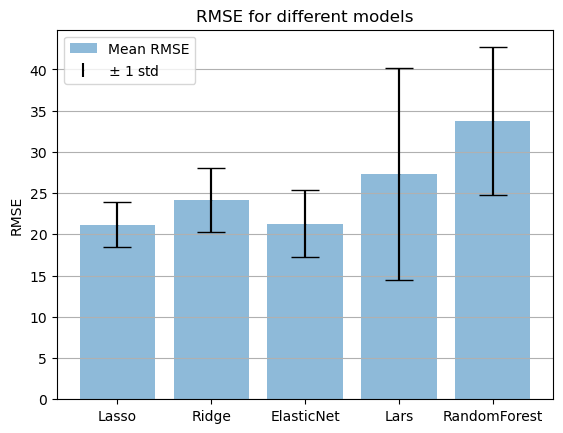

In [4]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars # , randomforrest, lars, iterativeimputer
from sklearn.ensemble import RandomForestRegressor

K_outer = 10
K_inner = 5
cv_outer = KFold(n_splits=K_outer, shuffle=True, random_state=42)
cv_inner = KFold(n_splits=K_inner, shuffle=True, random_state=42)

#Model parameters
alphas_lasso = np.linspace(0.1, 3, 10)
lambdas_ridge = np.linspace(5, 10, 10)
alphas_elastic = np.linspace(0.1, 10, 10)
l1_ratios_elastic = np.linspace(0.1, 1, 10)
nonzero_coefs_lars = range(16, 36, 2)
n_estimators_rf = range(10, 100, 10)

#Imputation parameters
neighbors = range(1, 20, 1)
methods = ['uniform', 'distance']

RMSE = {'Lasso': np.zeros(K_outer), 'Ridge': np.zeros(K_outer), 'ElasticNet': np.zeros(K_outer),
        'Lars': np.zeros(K_outer), 'RandomForest': np.zeros(K_outer)}
for k1, (train_index, test_index) in enumerate(cv_outer.split(X)):
    print('Outer fold:', k1+1, '/', K_outer)
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y_vec[train_index], y_vec[test_index]

    errors_lasso = np.zeros((K_inner, len(neighbors), len(methods), len(alphas_lasso)))
    errors_ridge = np.zeros((K_inner, len(neighbors), len(methods), len(lambdas_ridge)))
    errors_elastic = np.zeros((K_inner, len(neighbors), len(methods), len(alphas_elastic), len(l1_ratios_elastic)))
    errors_lars = np.zeros((K_inner, len(neighbors), len(methods), len(nonzero_coefs_lars)))
    errors_rf = np.zeros((K_inner, len(neighbors), len(methods), len(n_estimators_rf)))
    for k2, (train_index_inner, test_index_inner) in enumerate(cv_inner.split(Xtrain)):
        print('Inner fold:', k2+1, '/', K_inner)
        Xtrain_inner, Xtest_inner = Xtrain[train_index_inner], Xtrain[test_index_inner]
        ytrain_inner, ytest_inner = ytrain[train_index_inner], ytrain[test_index_inner]
        scaler, Xtrain_inner_norm, all_inner_data = custom_scale(StandardScaler(), Xtrain_inner, X_new)
        Xtest_inner_norm = custom_transform(scaler, Xtest_inner)
        
        for i, neigh in enumerate(neighbors):
            for m, method in enumerate(methods):
                imputer = KNNImputer(n_neighbors=neigh, weights=method).fit(all_inner_data)
                #Impute data
                Xtrain_inner_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_inner_norm))
                Xtest_inner_imputed = transform_to_categorical_bool(imputer.transform(Xtest_inner_norm))

                #Lasso
                for j, alpha in enumerate(alphas_lasso):
                    model = Lasso(alpha=alpha, max_iter=10000).fit(Xtrain_inner_imputed, ytrain_inner)
                    preds_inner_lasso = model.predict(Xtest_inner_imputed)
                    errors_lasso[k2, i, m, j] = np.sum((preds_inner_lasso - ytest_inner)**2) #Sum up all squared error
                #Ridge
                for j, lamb in enumerate(lambdas_ridge):
                    model = Ridge(alpha=lamb).fit(Xtrain_inner_imputed, ytrain_inner)
                    preds_inner_ridge = model.predict(Xtest_inner_imputed)
                    errors_ridge[k2, i, m, j] = np.sum((preds_inner_ridge - ytest_inner)**2)
                #ElasticNet
                for j, alpha in enumerate(alphas_elastic):
                    for l, l1_ratio in enumerate(l1_ratios_elastic):
                        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000).fit(Xtrain_inner_imputed, ytrain_inner)
                        preds_inner_elastic = model.predict(Xtest_inner_imputed)
                        errors_elastic[k2, i, m, j, l] = np.sum((preds_inner_elastic - ytest_inner)**2)
                #Lars
                for j, nzc in enumerate(nonzero_coefs_lars):
                    model = Lars(n_nonzero_coefs=nzc).fit(Xtrain_inner_imputed, ytrain_inner)
                    preds_inner_lars = model.predict(Xtest_inner_imputed)
                    errors_lars[k2, i, m, j] = np.sum((preds_inner_lars - ytest_inner)**2)
                #RandomForest
                for j, n_est in enumerate(n_estimators_rf):
                    model = RandomForestRegressor(n_estimators=n_est).fit(Xtrain_inner_imputed, ytrain_inner)
                    preds_inner_rf = model.predict(Xtest_inner_imputed)
                    errors_rf[k2, i, m, j] = np.sum((preds_inner_rf - ytest_inner)**2)
                

    scaler, Xtrain_norm, all_data = custom_scale(StandardScaler(), Xtrain, X_new)
    Xtest_norm = custom_transform(scaler, Xtest)

    model_dict_errors = {'Lasso': errors_lasso, 'Ridge': errors_ridge, 'ElasticNet': errors_elastic, 'Lars': errors_lars, 'RandomForest': errors_rf}

    for model, errors in model_dict_errors.items():
        mean_error = errors.mean(axis = 0)
        idx = np.unravel_index(np.argmin(mean_error, axis=None), mean_error.shape)
        imputer = KNNImputer(n_neighbors=neighbors[idx[0]], weights=methods[idx[1]]).fit(all_data)
        Xtrain_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_norm))
        Xtest_imputed = transform_to_categorical_bool(imputer.transform(Xtest_norm))
        if model == 'Lasso':
            best_inner = Lasso(alpha=alphas_lasso[idx[2]], max_iter=10000).fit(Xtrain_imputed, ytrain)
        elif model == 'Ridge':
            best_inner = Ridge(alpha=lambdas_ridge[idx[2]]).fit(Xtrain_imputed, ytrain)
        elif model == 'ElasticNet':
            best_inner = ElasticNet(alpha=alphas_elastic[idx[2]], l1_ratio=l1_ratios_elastic[idx[3]], max_iter=10000).fit(Xtrain_imputed, ytrain)
        elif model == 'Lars':
            best_inner = Lars(n_nonzero_coefs=nonzero_coefs_lars[idx[2]]).fit(Xtrain_imputed, ytrain)
        elif model == 'RandomForest':
            best_inner = RandomForestRegressor(n_estimators=n_estimators_rf[idx[2]]).fit(Xtrain_imputed, ytrain)
        preds_outer = best_inner.predict(Xtest_imputed)
        RMSE[model][k1] = np.sqrt(np.mean((preds_outer - ytest)**2))
        print('Optimal', model, ': neighbors: ', neighbors[idx[0]], ', method:', methods[idx[1]], ', RMSE:', round(RMSE[model][k1], 3))

print()
print('Lasso mean RMSE:', round(RMSE['Lasso'].mean(), 4), ', std:', round(RMSE['Lasso'].std(), 4))
print('Ridge mean RMSE:', round(RMSE['Ridge'].mean(), 4), ', std:', round(RMSE['Ridge'].std(), 4))
print('ElasticNet mean RMSE:', round(RMSE['ElasticNet'].mean(), 4), ', std:', round(RMSE['ElasticNet'].std(), 4))
print('Lars mean RMSE:', round(RMSE['Lars'].mean(), 4), ', std:', round(RMSE['Lars'].std(), 4))
print('RandomForest mean RMSE:', round(RMSE['RandomForest'].mean(), 4), ', std:', round(RMSE['RandomForest'].std(), 4))

fig, ax = plt.subplots()
models = list(RMSE.keys())
mean = [round(RMSE[model].mean(), 4) for model in models]
std = [round(RMSE[model].std(), 4) for model in models]
ax.bar(models, mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10, label='Mean RMSE')
ax.errorbar(models, mean, yerr=std, fmt='o', color='black', label='$\pm$ 1 std', markersize=0.1)
ax.legend()
ax.set_ylabel('RMSE')
ax.set_title('RMSE for different models')
ax.yaxis.grid(True)
#save the figure
plt.savefig('RMSE_models.png')

#save the RMSE dictionary
import pickle
with open('RMSE_dict.pkl', 'wb') as f:
    pickle.dump(RMSE, f)

In [ ]:
mean_error_lasso = errors_lasso.mean(axis = 0)
    idx_lasso = np.unravel_index(np.argmin(mean_error_lasso, axis=None), mean_error_lasso.shape)
    imputer = KNNImputer(n_neighbors=neighbors[idx_lasso[0]], weights=methods[idx_lasso[1]]).fit(all_data)
    Xtrain_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_norm))
    Xtest_imputed = transform_to_categorical_bool(imputer.transform(Xtest_norm))
    best_inner_lasso = Lasso(alpha=alphas_lasso[idx_lasso[2]], max_iter=10000).fit(Xtrain_imputed, ytrain)
    preds_outer_lasso = best_inner_lasso.predict(Xtest_imputed)
    RMSE['Lasso'][k1] = np.sqrt(np.mean((preds_outer_lasso - ytest)**2))
    print('Optimal Lasso: neighbors: ', neighbors[idx_lasso[0]], ', method:', methods[idx_lasso[1]],
           ', alpha: ', round(alphas_lasso[idx_lasso[2]], 3), ', RMSE:', round(RMSE['Lasso'][k1], 3))

    mean_error_ridge = errors_ridge.mean(axis = 0)
    idx_ridge = np.unravel_index(np.argmin(mean_error_ridge, axis=None), mean_error_ridge.shape)
    imputer = KNNImputer(n_neighbors=neighbors[idx_ridge[0]], weights=methods[idx_ridge[1]]).fit(all_data)
    Xtrain_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_norm))
    Xtest_imputed = transform_to_categorical_bool(imputer.transform(Xtest_norm))
    best_inner_ridge = Ridge(alpha=lambdas_ridge[idx_ridge[2]]).fit(Xtrain_imputed, ytrain)
    preds_outer_ridge = best_inner_ridge.predict(Xtest_imputed)
    RMSE['Ridge'][k1] = np.sqrt(np.mean((preds_outer_ridge - ytest)**2))
    print('Optimal Ridge: neighbors: ', neighbors[idx_ridge[0]], ', method:', methods[idx_ridge[1]], 
          ', lambda: ', round(lambdas_ridge[idx_ridge[2]], 3), ', RMSE:', round(RMSE['Ridge'][k1], 3))
    
    mean_error_elastic = errors_elastic.mean(axis = 0)
    idx_elastic = np.unravel_index(np.argmin(mean_error_elastic, axis=None), mean_error_elastic.shape)
    imputer = KNNImputer(n_neighbors=neighbors[idx_elastic[0]], weights=methods[idx_elastic[1]]).fit(all_data)
    Xtrain_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_norm))
    Xtest_imputed = transform_to_categorical_bool(imputer.transform(Xtest_norm))
    best_inner_elastic = ElasticNet(alpha=alphas_elastic[idx_elastic[2]], l1_ratio=l1_ratios_elastic[idx_elastic[3]], max_iter=10000).fit(Xtrain_imputed, ytrain)
    preds_outer_elastic = best_inner_elastic.predict(Xtest_imputed)
    RMSE['ElasticNet'][k1] = np.sqrt(np.mean((preds_outer_elastic - ytest)**2))
    print('Optimal ElasticNet: neighbors: ', neighbors[idx_elastic[0]], ', method:', methods[idx_elastic[1]], 
          ', alpha: ', round(alphas_elastic[idx_elastic[2]], 3), ', l1_ratio: ', round(l1_ratios_elastic[idx_elastic[3]], 3), 
          ', RMSE:', round(RMSE['ElasticNet'][k1], 3))
    
    mean_error_lars = errors_lars.mean(axis = 0)
    idx_lars = np.unravel_index(np.argmin(mean_error_lars, axis=None), mean_error_lars.shape)
    imputer = KNNImputer(n_neighbors=neighbors[idx_lars[0]], weights=methods[idx_lars[1]]).fit(all_data)
    Xtrain_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_norm))
    Xtest_imputed = transform_to_categorical_bool(imputer.transform(Xtest_norm))
    best_inner_lars = Lars(n_nonzero_coefs=nonzero_coefs_lars[idx_lars[2]]).fit(Xtrain_imputed, ytrain)
    preds_outer_lars = best_inner_lars.predict(Xtest_imputed)
    RMSE['Lars'][k1] = np.sqrt(np.mean((preds_outer_lars - ytest)**2))
    print('Optimal Lars: neighbors: ', neighbors[idx_lars[0]], ', method:', methods[idx_lars[1]], 
          ', n_nonzero_coefs: ', nonzero_coefs_lars[idx_lars[2]], ', RMSE:', round(RMSE['Lars'][k1], 3))
    
    mean_error_rf = errors_rf.mean(axis = 0)
    idx_rf = np.unravel_index(np.argmin(mean_error_rf, axis=None), mean_error_rf.shape)
    imputer = KNNImputer(n_neighbors=neighbors[idx_rf[0]], weights=methods[idx_rf[1]]).fit(all_data)
    Xtrain_imputed = transform_to_categorical_bool(imputer.transform(Xtrain_norm))
    Xtest_imputed = transform_to_categorical_bool(imputer.transform(Xtest_norm))
    best_inner_rf = RandomForestRegressor(n_estimators=n_estimators_rf[idx_rf[2]]).fit(Xtrain_imputed, ytrain)
    preds_outer_rf = best_inner_rf.predict(Xtest_imputed)
    RMSE['RandomForest'][k1] = np.sqrt(np.mean((preds_outer_rf - ytest)**2))
    print('Optimal RandomForest: neighbors: ', neighbors[idx_rf[0]], ', method:', methods[idx_rf[1]], 
          ', n_estimators: ', n_estimators_rf[idx_rf[2]], ', RMSE:', round(RMSE['RandomForest'][k1], 3))
